# Who let 'some' dogs out? 🐾

Final Project: Dog breed detection

A little info:

*   The dataset consist in a folder with 10222 images of dogs and a csv with 120 breeds
*   I got the data from Kaggle but edited it a bit (since there where no dachshunds and dachshunds = 💗)
*   This is a model with only some breeds, the original notebook project with the 120 breeds was made on google colab and it's called 'Who let the dogs out?'

In [1]:
# packages
import cv2
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import os
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
import PIL.Image
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model

## EDA

In [2]:
# loading & checking data: breeds
dogbreeds = pd.read_csv('dog-breeds/labelsbreeds.csv')
dogbreeds

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [3]:
dogbreeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [4]:
dogbreeds['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

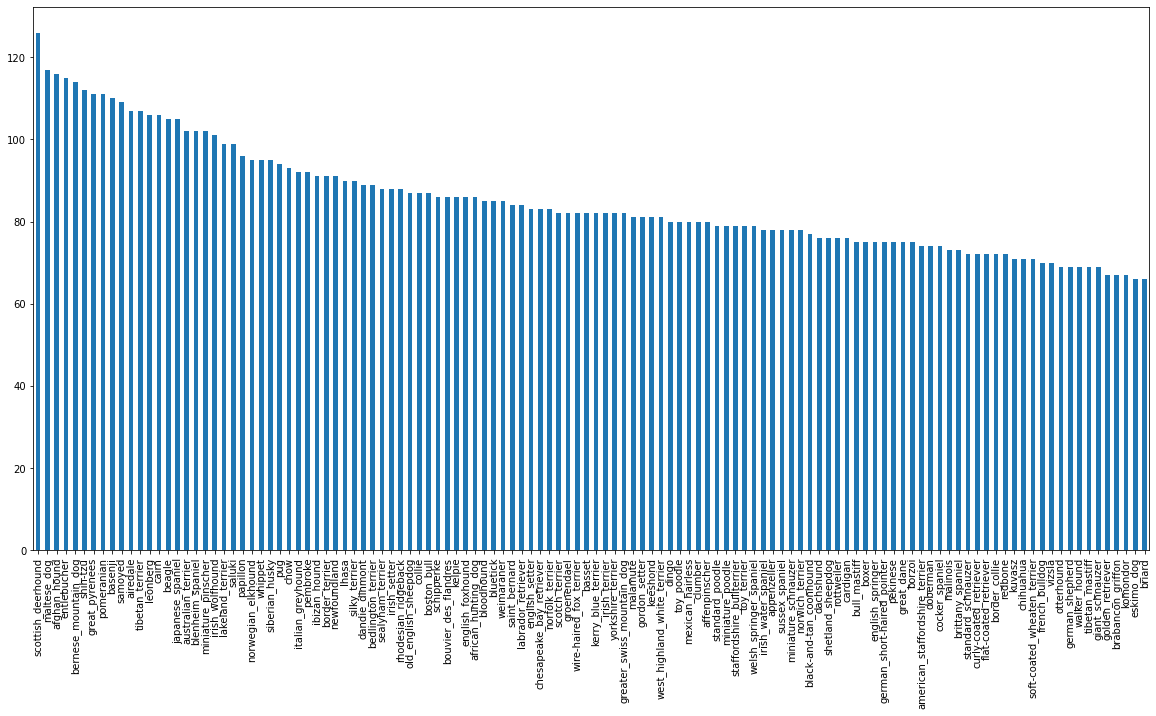

In [5]:
# visualizing the amount of pictures of each breed
dogbreeds['breed'].value_counts().plot.bar(figsize=(20, 10));

In [6]:
# checking the breeds
dogbreeds['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dachshund', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'b

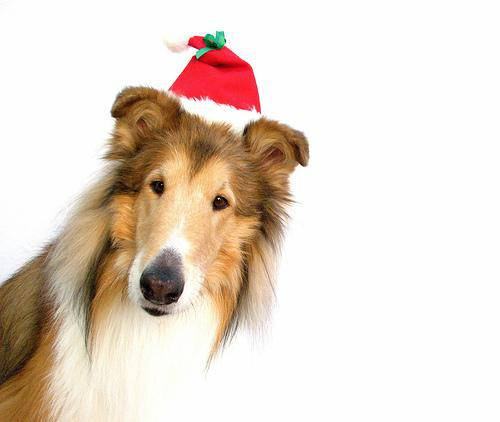

In [7]:
# naming the picture folders
train_images = 'dog-breeds/trainbreeds/'
test_images = 'dog-breeds/test/' # I won't use it, but just in case
# checking a random picture
Image('dog-breeds/trainbreeds/0a6c192b96e55e2ca37318919b1ffae6.jpg')

A festive cutie!

In [41]:
# get the image path in the csv file
dogs['image_path'] = dogbreeds['id'].apply(lambda x: x + ".jpg")
dogs

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,ffe5f6d8e2bff356e9482a80a6e29aac.jpg


In [42]:
# got to make sure I don't have any nulls there since I edited the original data
dogs.isna().sum()

id            0
breed         0
image_path    0
dtype: int64

In [43]:
# checking if it works, if I call the id of the picture before I shold get a... border collie?
dogs.loc[dogs['id'] == '0a6c192b96e55e2ca37318919b1ffae6']

,id,breed,image_path
434,0a6c192b96e55e2ca37318919b1ffae6,collie,0a6c192b96e55e2ca37318919b1ffae6.jpg


In [44]:
# checking one more because: dogs
dogs['breed'][42]

'dachshund'

In [45]:
# locating the id to find the picture
dogs.iloc[42]

id                011e06760794850c40f23d6426c40774
breed                                    dachshund
image_path    011e06760794850c40f23d6426c40774.jpg
Name: 42, dtype: object

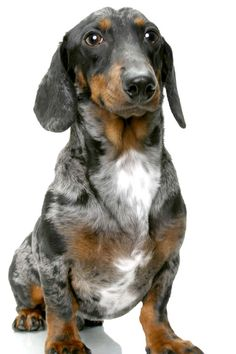

In [46]:
Image('dog-breeds/trainbreeds/011e06760794850c40f23d6426c40774.jpg')

❤️

### Reducing breeds

I'm going to work with 10 breeds only on my first attempt. The selection is based on breeds I can recognize and also look quite different to see if this helps the model

In [47]:
# making a copy of the data just in case
somedogs = dogs.copy()

In [48]:
somedogs = somedogs.loc[somedogs['breed'].isin(['dachshund','golden_retriever', 'chow', 'siberian_husky', 
                                                'great_dane', 'french_bulldog', 'rottweiler', 'cocker_spaniel', 
                                                'pekinese', 'doberman'])]
somedogs.reset_index(drop=True, inplace=True)
somedogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          775 non-null    object
 1   breed       775 non-null    object
 2   image_path  775 non-null    object
dtypes: object(3)
memory usage: 18.3+ KB


In [49]:
somedogs['breed'].value_counts()

siberian_husky      95
chow                93
dachshund           76
rottweiler          76
pekinese            75
great_dane          75
doberman            74
cocker_spaniel      74
french_bulldog      70
golden_retriever    67
Name: breed, dtype: int64

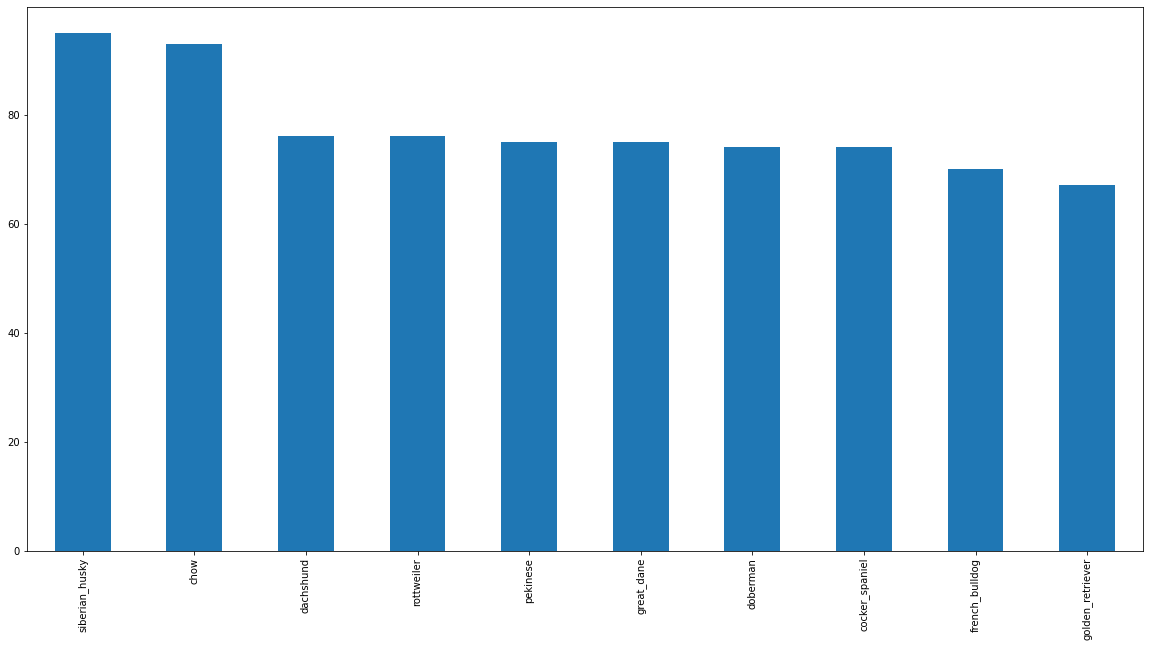

In [50]:
# the amount of pictures of each breed is quite similar
somedogs['breed'].value_counts().plot.bar(figsize=(20, 10));

## Preproccesing the data

I need to resize my images (going to use 224 x 224), add a color layer (RGB: 3), turn the images into arrays and scale that array from -1 to 1. Thankfully Google exists so I found a code I could adapt to my scenario

### X

In [53]:
# np.zeros gives me an array of... you guessed it! zeroes
# np.zeros(amount of values, image size, image size, rgb layer)
X = np.zeros((len(somedogs), 224, 224, 3), dtype='float32')
 
# now the for loop:
for i, image in enumerate(somedogs['image_path']):
# this part reads the image, resizes it, adds the color layer and converts it to an array, for free!
    img = cv2.resize(cv2.imread(train_images + image, cv2.IMREAD_COLOR),((224, 224)))
# this part scales the array from -1 to 1 and expands it on the 0 axis, apparently
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
# and now I add the new creation into the array made of zeroes
    X[i] = img_array

### y

In [54]:
# converting breed names into numericals
y = LabelEncoder().fit_transform(somedogs['breed'].values)

### Splitting

In [64]:
#split the dataset: 70% for training and 30% for testing. Randomness at 42 because it's the answer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(542, 224, 224, 3)
(542,)
(233, 224, 224, 3)
(233,)


### 'Adding' more images: image augmentation

Apparently to be able to improve the model I can 'create' more images from the ones I already have by adding settings like rotations, movement shifts, zooms, etc

In [56]:
#Image augmentation using ImageDataGenerator class
train_data = ImageDataGenerator(rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.25,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
 
# generate images for training sets, batch size is the amount of pictures
train_generator = train_data.flow(X_train, y_train, batch_size = 16)
 
# now onto the testing
test_data = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, y_test, batch_size = 16)

## Model: ResNet50

In [57]:
resnet = ResNet50V2(input_shape = [224, 224, 3], weights = 'imagenet', include_top = False)
#freeze all trainable layers and train only top layers 
for layer in resnet.layers:
    layer.trainable = False
#add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# add fully connected layer
x = Dense(10, activation = 'relu')(x)
x = Dropout(0.5)(x)

In [58]:
# output layer number must be the amount of breeds I'm using
predictions = Dense(10, activation = 'softmax')(x)
#create model class with inputs and outputs
model = Model(inputs = resnet.input, outputs = predictions)

In [59]:
# build the model
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])
 
#fit the training generator data and train the model
history = model.fit(train_generator, epochs = 25, validation_data = test_generator)
 
#Save the model for prediction
#model.save("model")

Epoch 1/25
34/34 [==============================] - 68s 2s/step - loss: 2.3544 - accuracy: 0.1183 - val_loss: 2.0122 - val_accuracy: 0.2661
Epoch 2/25
34/34 [==============================] - 74s 2s/step - loss: 2.1730 - accuracy: 0.1997 - val_loss: 1.8091 - val_accuracy: 0.3948
Epoch 3/25
34/34 [==============================] - 79s 2s/step - loss: 2.0024 - accuracy: 0.2328 - val_loss: 1.6687 - val_accuracy: 0.4506
Epoch 4/25
34/34 [==============================] - 82s 2s/step - loss: 1.9494 - accuracy: 0.2994 - val_loss: 1.5807 - val_accuracy: 0.4850
Epoch 5/25
34/34 [==============================] - 80s 2s/step - loss: 1.9181 - accuracy: 0.2857 - val_loss: 1.5000 - val_accuracy: 0.5064
Epoch 6/25
34/34 [==============================] - 80s 2s/step - loss: 1.8133 - accuracy: 0.3290 - val_loss: 1.4231 - val_accuracy: 0.5494
Epoch 7/25
34/34 [==============================] - 82s 2s/step - loss: 1.7486 - accuracy: 0.3696 - val_loss: 1.3587 - val_accuracy: 0.6137
Epoch 8/25
34/34 [==

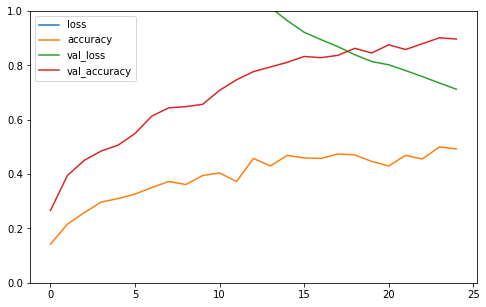

In [60]:
# plotting the values
pd.DataFrame(history.history).plot(figsize = (8,5))
pyplot.grid= (True)
pyplot.gca().set_ylim(0, 1)
pyplot.show();